https://github.com/subbareddy248/WSNET/blob/main/Code/Medical_CNN_Linknet-Local.py

In [1]:
from src.WSNET.Medical_CNN_Linknet_Local import get_linknet_local_model
model_1, train_gen, val_gen = get_linknet_local_model()

Segmentation Models: using `tf.keras` framework.


/Users/zianor/Documents/repos/DLIV-chronic-wound-segmentation/venv/lib/python3.8/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
2023-11-28 13:31:48.200595: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-28 13:31:48.200617: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2023-11-28 13:31:48.200621: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2023-11-28 13:31:48.200656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 13:31:48.200677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 create_patches (CreatePatc  [(None, 48, 48, 3),          0         ['input_1[0][0]']             
 hes)                         (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                                  
                              (None, 48, 48, 3),                                            

1/1 [==============================] - 1s 519ms/step


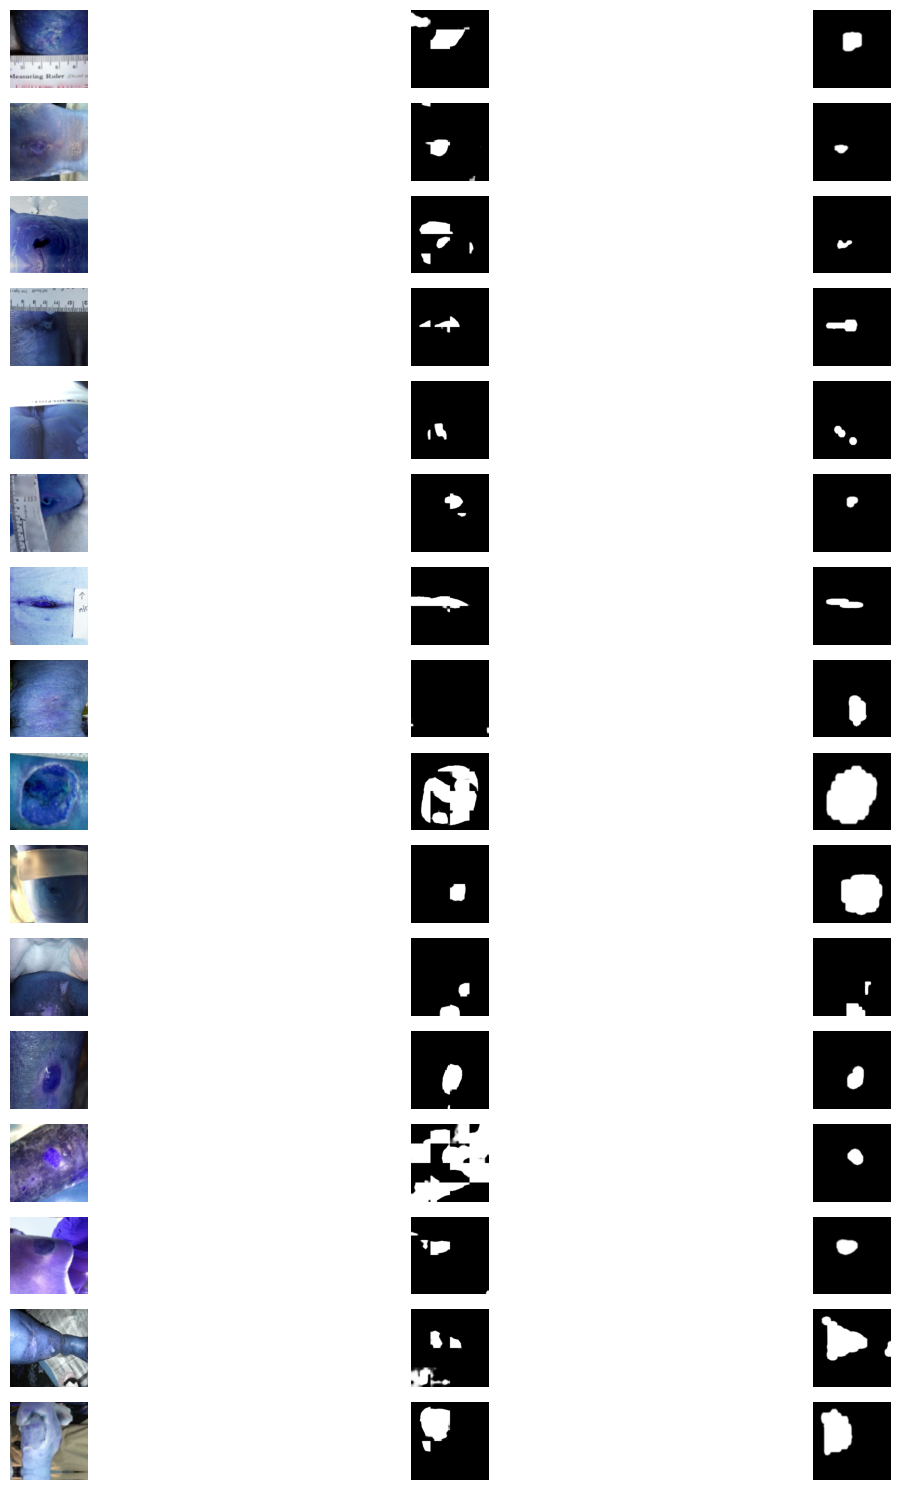

In [3]:
import matplotlib.pyplot as plt

BATCH_SIZE = 16

for image, label in val_gen:
    res = model_1.predict(image)
    plt.subplots(BATCH_SIZE, 3, figsize=(15,15))
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE,3,i*3 + 1)
        plt.imshow(image[i, :, :, :])
        plt.axis('off')
        plt.subplot(BATCH_SIZE,3, i*3 + 2)
        plt.imshow(res[i, :, : , :], cmap='gray')
        plt.axis('off')
        plt.subplot(BATCH_SIZE,3, i*3 + 3)
        plt.imshow(label[i, :, : , :], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break